# 70 Reprojecting Seismic Data and extracting path and CDP points from Seismic Data

This notebook illustrates how to reproject 2D seismic data from the original coordinate system to a new coordinate system. In this tutorial, we are making use of the `segysak` package (https://segysak.readthedocs.io/en/latest/) to load the seismic data in combination with `GeoPandas` (https://geopandas.org/en/stable/) to perform the coordinate reprojection. Further, it is shown how to export the path of the seismic data as LineString, as CDP points and as points every n-th meter along the line.

<img src="../images/tutorial70_cover.png">

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# import gemgis as gg
import geopandas as gpd
import matplotlib.pyplot as plt
from typing import Union
import pyproj
import numpy as np
import shapely
from shapely.geometry import LineString

In [2]:
file_path ='data/70_reprojecting_seismic_data/'
# gg.download_gemgis_data.download_tutorial_data(filename="70_reprojecting_seismic_data.zip", dirpath=file_path)

## Defining functions

As there may be conflicts between the dependencies of GemGIS and the `segysak` package, we define the functions that are needed to reproject the seismic data and for the further contents of the notebook. However, they are also implemented in the GemGIS `utils` module. 

In [3]:
def convert_crs_seismic_data(path_in: str,
                             path_out: str,
                             crs_in: Union[str, pyproj.crs.crs.CRS],
                             crs_out: Union[str, pyproj.crs.crs.CRS],
                             cdpx: int = 181,
                             cdpy: int = 185,
                             vert_domain: str = 'TWT',
                             coord_scalar: int = None):
    """Convert CDP coordinates of seismic data to a new CRS.

    Parameters
    __________
        path_in : str
            Path to the original seismic data, e.g. ``path_in='seismic.sgy'``.
        path_out : str
            Path to the converted seismic data, e.g. ``path_out='seismic_converted.sgy'``.
        crs_in : str, pyproj.crs.crs.CRS
            Coordinate reference system of the original seismic data.
        crs_out : str, pyproj.crs.crs.CRS
            Coordinate reference system of the converted seismic data.
        cdpx : int
            Byte position for the X coordinates, default is ``cdpx=181``.
        cdpy : int
            Byte position for the Y coordinates, default is ``cdpx=185``.
        vert_domain : str
            Vertical sampling domain. Options include ``'TWT'`` and ``'DEPTH'``, default is ``vert_domain='TWT'``.
        coord_scalar: int
            Coordinate scalar value to set if `NaN` columns are returned, default is `coord_scalar=None`. 

    .. versionadded:: 1.1.1

    """
    # Trying to import segysak but returning error if segysak is not installed
    try:
        from segysak.segy import segy_loader, segy_writer
    except ModuleNotFoundError:
        raise ModuleNotFoundError(
            'segysak package is not installed. Use pip install segysak to install the latest version')

    # Checking that path_in is of type string
    if not isinstance(path_in, str):
        raise TypeError('path_in must be provided as string')

    # Checking that path_out is of type string
    if not isinstance(path_out, str):
        raise TypeError('path_out must be provided as string')

    # Checking that crs_in is of type string or pyproj CRS
    if not isinstance(crs_in, (str, pyproj.crs.crs.CRS)):
        raise TypeError('crs_in must be provided as string or pyproj CRS')

    # Checking that crs_out is of type string or pyproj CRS
    if not isinstance(crs_out, (str, pyproj.crs.crs.CRS)):
        raise TypeError('crs_out must be provided as string or pyproj CRS')

    # Checking that vert_domain is of type str
    if not isinstance(vert_domain, str):
        raise TypeError('vert_domain must be provided as string')

    # Checking that the coord_scalar is of type int or None
    if not isinstance(coord_scalar, (int, type(None))):
        raise TypeError('coord_scalar must be provided as int')        

    # Loading seismic data
    seismic = segy_loader(path_in,
                          vert_domain=vert_domain,
                          cdpx=cdpx,
                          cdpy=cdpy)

    # Converting Seismic to DataFrame
    df_seismic = seismic.to_dataframe()

    # Checking that the CDP coordinates are in the DataFrame
    if not {'cdp_x', 'cdp_y'}.issubset(df_seismic.columns):
        raise ValueError(
            'No coordinates found, please provide the byte positions where the X and Y data of the CDPs is stored')

    # Extracting the length of the samples to reduce computing time
    samples = len(df_seismic.index.get_level_values(1).unique())

    # Resample DataFrame
    df_seismic_resampled = df_seismic[::samples]

    # Reprojecting Coordinates
    df_seismic_reprojected = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=df_seismic_resampled['cdp_x'].values,
                                                                          y=df_seismic_resampled['cdp_y'].values),
                                              crs=crs_in).to_crs(crs_out)

    # Extracting reprojected coordinates
    x = df_seismic_reprojected.geometry.x.values
    y = df_seismic_reprojected.geometry.y.values

    # Assigning new coordinates
    seismic['cdp_x'][:] = x
    seismic['cdp_y'][:] = y

    # Optionally setting a new coord_scalar
    if coord_scalar:
        seismic.attrs['coord_scalar'] = coord_scalar

    # Saving reprojected seismic data to file
    segy_writer(seismic,
                path_out,
                trace_header_map=dict(cdp_x=181,
                                      cdp_y=185))

    print('Seismic data was successfully reprojected and saved to file')


def get_cdp_linestring_of_seismic_data(path_in: str,
                                       crs_in: Union[str, pyproj.crs.crs.CRS],
                                       cdpx: int = 181,
                                       cdpy: int = 185,
                                       vert_domain: str = 'TWT'):
    """Extracting the path of the seismic data as LineString.

    Parameters
    __________
        path_in : str
            Path to the original seismic data, e.g. ``path_in='seismic.sgy'``.
        crs_in : str, pyproj.crs.crs.CRS
            Coordinate reference system of the original seismic data.
        cdpx : int
            Byte position for the X coordinates, default is ``cdpx=181``.
        cdpy : int
            Byte position for the Y coordinates, default is ``cdpx=185``.
        vert_domain : str
            Vertical sampling domain. Options include ``'TWT'`` and ``'DEPTH'``, default is ``vert_domain='TWT'``.

    Returns
    _______
        gpd.GeoDataFrame
            GeoDataFrame containing the surface path of the seismic data as LineString.

    .. versionadded:: 1.1.1

    """
    # Trying to import segysak but returning error if segysak is not installed
    try:
        from segysak.segy import segy_loader, segy_writer
    except ModuleNotFoundError:
        raise ModuleNotFoundError(
            'segysak package is not installed. Use pip install segysak to install the latest version')

    # Checking that path_in is of type string
    if not isinstance(path_in, str):
        raise TypeError('path_in must be provided as string')

    # Checking that crs_in is of type string or pyproj CRS
    if not isinstance(crs_in, (str, pyproj.crs.crs.CRS)):
        raise TypeError('crs_in must be provided as string or pyproj CRS')

    # Checking that vert_domain is of type str
    if not isinstance(vert_domain, str):
        raise TypeError('vert_domain must be provided as string')

    # Loading seismic data
    seismic = segy_loader(path_in,
                          vert_domain=vert_domain,
                          cdpx=cdpx,
                          cdpy=cdpy)

    # Converting Seismic to DataFrame
    df_seismic = seismic.to_dataframe()

    # Checking that the CDP coordinates are in the DataFrame
    if not {'cdp_x', 'cdp_y'}.issubset(df_seismic.columns):
        raise ValueError(
            'No coordinates found, please provide the byte positions where the X and Y data of the CDPs is stored')

    # Extracting the length of the samples to reduce computing time
    samples = len(df_seismic.index.get_level_values(1).unique())

    # Resample DataFrame
    df_seismic_resampled = df_seismic[::samples]

    # Creating LineString from coordinates
    linestring = LineString(np.c_[(df_seismic_resampled['cdp_x'].values,
                                   df_seismic_resampled['cdp_y'].values)])

    # Reprojecting Coordinates
    gdf_seismic = gpd.GeoDataFrame(geometry=[linestring],
                                   crs=crs_in)

    return gdf_seismic


def get_cdp_points_of_seismic_data(path_in: str,
                                   crs_in: Union[str, pyproj.crs.crs.CRS],
                                   cdpx: int = 181,
                                   cdpy: int = 185,
                                   vert_domain: str = 'TWT',
                                   filter: int = None,
                                   n_meter: Union[int, float] = None):
    """Extracting the path of the seismic data as LineString.

    Parameters
    __________
        path_in : str
            Path to the original seismic data, e.g. ``path_in='seismic.sgy'``.
        crs_in : str, pyproj.crs.crs.CRS
            Coordinate reference system of the original seismic data.
        cdpx : int
            Byte position for the X coordinates, default is ``cdpx=181``.
        cdpy : int
            Byte position for the Y coordinates, default is ``cdpx=185``.
        vert_domain : str
            Vertical sampling domain. Options include ``'TWT'`` and ``'DEPTH'``, default is ``vert_domain='TWT'``.
        filter : int
            Filtering the points to only return every n-th point, e.g. ``filter=100`` to return only every 100-th point.
        n_meter : int, float
            Parameter to select a point along the line every n-th meter.

    Returns
    _______
        gpd.GeoDataFrame
            GeoDataFrame containing the CDPs as Points.

    .. versionadded:: 1.1.1

    """
    # Trying to import segysak but returning error if segysak is not installed
    try:
        from segysak.segy import segy_loader, segy_writer
    except ModuleNotFoundError:
        raise ModuleNotFoundError(
            'segysak package is not installed. Use pip install segysak to install the latest version')

    # Checking that path_in is of type string
    if not isinstance(path_in, str):
        raise TypeError('path_in must be provided as string')

    # Checking that crs_in is of type string or pyproj CRS
    if not isinstance(crs_in, (str, pyproj.crs.crs.CRS)):
        raise TypeError('crs_in must be provided as string or pyproj CRS')

    # Checking that vert_domain is of type str
    if not isinstance(vert_domain, str):
        raise TypeError('vert_domain must be provided as string')

    # Loading seismic data
    seismic = segy_loader(path_in,
                          vert_domain=vert_domain,
                          cdpx=cdpx,
                          cdpy=cdpy)

    # Converting Seismic to DataFrame
    df_seismic = seismic.to_dataframe()

    # Checking that the CDP coordinates are in the DataFrame
    if not {'cdp_x', 'cdp_y'}.issubset(df_seismic.columns):
        raise ValueError(
            'No coordinates found, please provide the byte positions where the X and Y data of the CDPs is stored')

    # Extracting the length of the samples to reduce computing time
    samples = len(df_seismic.index.get_level_values(1).unique())

    # Resample DataFrame
    df_seismic_resampled = df_seismic[::samples]

    if n_meter:

        # Creating LineString from coordinates
        linestring = LineString(np.c_[(df_seismic_resampled['cdp_x'].values,
                                       df_seismic_resampled['cdp_y'].values)])

        # Defining number of samples
        samples = np.arange(0, round(linestring.length / n_meter) + 1, 1)

        # Getting points every n_meter
        points = [shapely.line_interpolate_point(linestring, n_meter * sample) for sample in samples]

        # Creating GeoDataFrame from points
        gdf_seismic = gpd.GeoDataFrame(geometry=points,
                                       crs=crs_in)

        # Appending distance
        gdf_seismic['distance'] = samples * n_meter

    else:
        # Creating Points from coordinates
        gdf_seismic = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=df_seismic_resampled['cdp_x'].values,
                                                                   y=df_seismic_resampled['cdp_y'].values),
                                       data=df_seismic_resampled,
                                       crs=crs_in).reset_index().drop(['twt', 'data'], axis=1)

        # Returning only every nth point
        if filter:
            gdf_seismic = gdf_seismic[::filter]

    return gdf_seismic

## Reprojecting Seismic Data

The seismic data used here can be freely downloaded from NLOG.nl and is provided in the Coordinate References System (CRS) with `EPSG:28992`. To reproject the data, we are using the function `convert_crs_seismic_data(...)`. The output path and the output CRS are defined, optionally, the byte positions for the X and Y coordinates of each CDP and the vertical domain can be defined. 

In [4]:
convert_crs_seismic_data(path_in=file_path+'Seismic_EPSG_28992.sgy',
                         path_out=file_path+'Seismic_EPSG_25832.sgy',
                         crs_in='EPSG:28992',
                         crs_out='EPSG:25832',
                         cdpx = 181,
                         cdpy = 185,
                         vert_domain = 'TWT')

  0%|          | 0.00/2.70k [00:00<?, ? traces/s]

Loading as 2D


Converting SEGY:   0%|          | 0.00/2.70k [00:00<?, ? traces/s]

Seismic data was successfully reprojected and saved to file


## Accounting for coordinate scalar errors

It may happen that columns are filled with `NaN` values. The problem is not so much the Python side but the SEGY side. For a more detailed description, see https://github.com/trhallam/segysak/issues/109#issuecomment-1717610828. The error can be mitigated by providing a `coord_scalar` value. 

In [5]:
from segysak.segy import segy_loader
seismic = segy_loader(file_path+'Seismic_EPSG_25832.sgy',
                         cdpx = 181,
                         cdpy = 185,
                         vert_domain = 'TWT')

# Converting Seismic to DataFrame
df_seismic = seismic.to_dataframe()
df_seismic

  0%|          | 0.00/2.70k [00:00<?, ? traces/s]

Loading as 2D


Converting SEGY:   0%|          | 0.00/2.70k [00:00<?, ? traces/s]

data         cdp_x  cdp_y
cdp  twt                              
1    0.0      0.0  287958.90625    NaN
     2.0      0.0  287958.90625    NaN
     4.0      0.0  287958.90625    NaN
     6.0      0.0  287958.90625    NaN
     8.0      0.0  287958.90625    NaN
...           ...           ...    ...
2702 5092.0   0.0  314511.46875    NaN
     5094.0   0.0  314511.46875    NaN
     5096.0   0.0  314511.46875    NaN
     5098.0   0.0  314511.46875    NaN
     5100.0   0.0  314511.46875    NaN

[6892802 rows x 3 columns]

## Reprojecting Seismic Data - again

As you can see, reprojecting the seismic data again using a `coord_scalar` will add the correct coordinates to the segy file.

In [6]:
convert_crs_seismic_data(path_in=file_path+'Seismic_EPSG_28992.sgy',
                         path_out=file_path+'Seismic_EPSG_25832.sgy',
                         crs_in='EPSG:28992',
                         crs_out='EPSG:25832',
                         cdpx = 181,
                         cdpy = 185,
                         vert_domain = 'TWT',
                         coord_scalar=-100)

  0%|          | 0.00/2.70k [00:00<?, ? traces/s]

Loading as 2D


Converting SEGY:   0%|          | 0.00/2.70k [00:00<?, ? traces/s]

Seismic data was successfully reprojected and saved to file


In [7]:
from segysak.segy import segy_loader
seismic = segy_loader(file_path+'Seismic_EPSG_25832.sgy',
                         cdpx = 181,
                         cdpy = 185,
                         vert_domain = 'TWT')

# Converting Seismic to DataFrame
df_seismic = seismic.to_dataframe()
df_seismic

  0%|          | 0.00/2.70k [00:00<?, ? traces/s]

Loading as 2D


Converting SEGY:   0%|          | 0.00/2.70k [00:00<?, ? traces/s]

data        cdp_x      cdp_y
cdp  twt                                 
1    0.0      0.0  287958.8750  5702121.5
     2.0      0.0  287958.8750  5702121.5
     4.0      0.0  287958.8750  5702121.5
     6.0      0.0  287958.8750  5702121.5
     8.0      0.0  287958.8750  5702121.5
...           ...          ...        ...
2702 5092.0   0.0  314511.4375  5700494.0
     5094.0   0.0  314511.4375  5700494.0
     5096.0   0.0  314511.4375  5700494.0
     5098.0   0.0  314511.4375  5700494.0
     5100.0   0.0  314511.4375  5700494.0

[6892802 rows x 3 columns]

## Plotting the results

In [8]:
seismic_old = segy_loader(file_path+'Seismic_EPSG_28992.sgy',
                          vert_domain='TWT',
                          cdpx=181,
                          cdpy=185)
# Converting Seismic to DataFrame
df_seismic_old = seismic_old.to_dataframe()
df_seismic_old

  0%|          | 0.00/2.70k [00:00<?, ? traces/s]

Loading as 2D


Converting SEGY:   0%|          | 0.00/2.70k [00:00<?, ? traces/s]

data          cdp_x        cdp_y
cdp  twt                                     
1    0.0      0.0  194105.421875  382534.0625
     2.0      0.0  194105.421875  382534.0625
     4.0      0.0  194105.421875  382534.0625
     6.0      0.0  194105.421875  382534.0625
     8.0      0.0  194105.421875  382534.0625
...           ...            ...          ...
2702 5092.0   0.0  220702.828125  382218.6250
     5094.0   0.0  220702.828125  382218.6250
     5096.0   0.0  220702.828125  382218.6250
     5098.0   0.0  220702.828125  382218.6250
     5100.0   0.0  220702.828125  382218.6250

[6892802 rows x 3 columns]

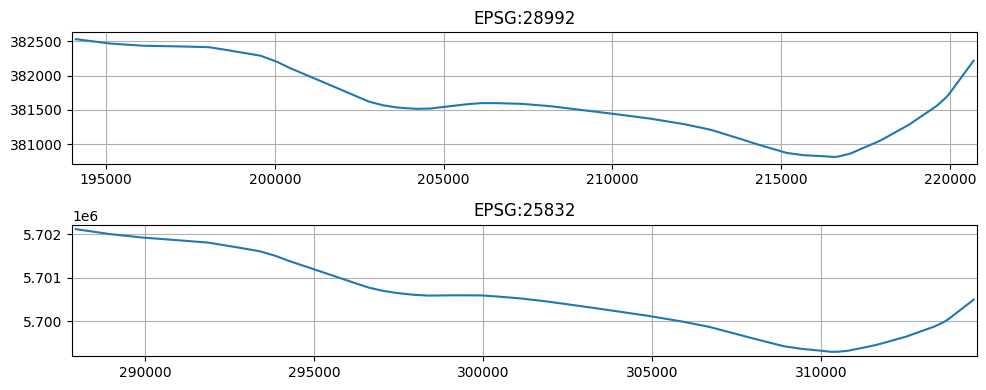

In [9]:
fig, ax = plt.subplots(2, figsize = (10,4))

ax[0].plot(df_seismic_old[::2551]['cdp_x'], df_seismic_old[::2551]['cdp_y'])
ax[0].grid()

ax[0].set_xlim(min(df_seismic_old[::2551]['cdp_x'])-100, max(df_seismic_old[::2551]['cdp_x'])+100) 
ax[0].set_ylim(min(df_seismic_old[::2551]['cdp_y'])-100, max(df_seismic_old[::2551]['cdp_y'])+100) 
ax[0].set_title('EPSG:28992')

ax[1].plot(df_seismic[::2551]['cdp_x'], df_seismic[::2551]['cdp_y'])
ax[1].grid()

ax[1].set_xlim(min(df_seismic[::2551]['cdp_x'])-100, max(df_seismic[::2551]['cdp_x'])+100) 
ax[1].set_ylim(min(df_seismic[::2551]['cdp_y'])-100, max(df_seismic[::2551]['cdp_y'])+100) 
ax[1].set_title('EPSG:25832')

plt.tight_layout()

## Extracting the path of the seismic data

The path of the seismic data can be extracted using the function `get_cdp_linestring_of_seismic_data`. A GeoDataFrame containing a LineString will be returned. 

In [10]:
gdf_linestring = get_cdp_linestring_of_seismic_data(path_in=file_path+'Seismic_EPSG_28992.sgy',
                                                    crs_in='EPSG:28992')
gdf_linestring

  0%|          | 0.00/2.70k [00:00<?, ? traces/s]

Loading as 2D


Converting SEGY:   0%|          | 0.00/2.70k [00:00<?, ? traces/s]

,geometry
0,"LINESTRING (194105.422 382534.062, 194115.391 ..."


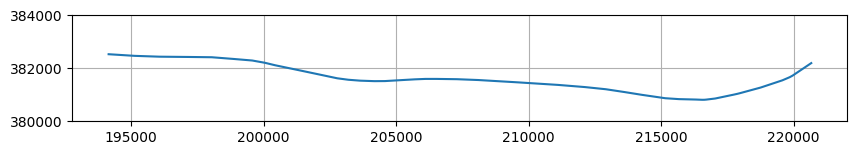

In [11]:
fig, ax = plt.subplots(1, figsize=(10,10))

gdf_linestring.plot(ax=ax)

ax.set_ylim(380000,384000)
ax.grid()

## Extracting the CDP points of the seismic data

The CDP points of the seismic data can be extracted using the function `get_cdp_points_of_seismic_data`. By setting a `filter`, only the n-th point can be selected. A GeoDataFrame containing points will be returned. 

In [12]:
gdf_points = get_cdp_points_of_seismic_data(path_in=file_path+'Seismic_EPSG_28992.sgy',
                                            crs_in='EPSG:28992',
                                            filter=250)
gdf_points

  0%|          | 0.00/2.70k [00:00<?, ? traces/s]

Loading as 2D


Converting SEGY:   0%|          | 0.00/2.70k [00:00<?, ? traces/s]

,cdp,cdp_x,cdp_y,geometry
0,1,194105.421875,382534.06250,POINT (194105.422 382534.062)
250,251,196602.859375,382433.34375,POINT (196602.859 382433.344)
500,501,199099.406250,382333.03125,POINT (199099.406 382333.031)
750,751,201554.859375,381880.46875,POINT (201554.859 381880.469)
1000,1001,204022.796875,381520.40625,POINT (204022.797 381520.406)
1250,1251,206520.484375,381599.18750,POINT (206520.484 381599.188)
1500,1501,209018.203125,381503.37500,POINT (209018.203 381503.375)
1750,1751,211512.828125,381340.65625,POINT (211512.828 381340.656)
2000,2001,213993.937500,381043.43750,POINT (213993.938 381043.438)
2250,2251,216479.656250,380814.06250,POINT (216479.656 380814.062)


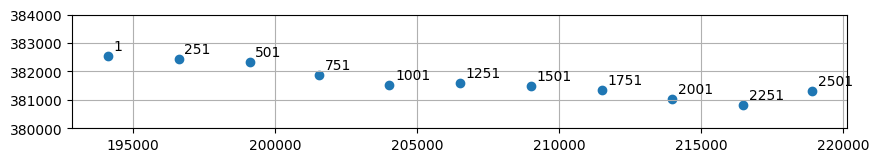

In [13]:
fig, ax = plt.subplots(1, figsize=(10,10))

for label, x, y in zip(gdf_points['cdp'], gdf_points['cdp_x'], gdf_points['cdp_y']):
    plt.text(x+200,y+200,label)
    
gdf_points.plot(ax=ax)

ax.set_ylim(380000,384000)
ax.grid()

## Extracting the CDP Points every n-th meter

In [14]:
gdf_points = get_cdp_points_of_seismic_data(path_in=file_path+'Seismic_EPSG_28992.sgy',
                                            crs_in='EPSG:28992',
                                            n_meter=4000)
gdf_points.head()

  0%|          | 0.00/2.70k [00:00<?, ? traces/s]

Loading as 2D


Converting SEGY:   0%|          | 0.00/2.70k [00:00<?, ? traces/s]

,geometry,distance
0,POINT (194105.422 382534.062),0
1,POINT (198102.572 382412.468),4000
2,POINT (202044.081 381777.218),8000
3,POINT (206020.565 381595.751),12000
4,POINT (210016.378 381442.716),16000


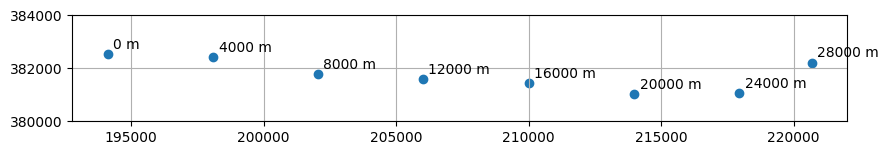

In [15]:
fig, ax = plt.subplots(1, figsize=(10,10))

for label, x, y in zip(gdf_points['distance'], gdf_points.geometry.x, gdf_points.geometry.y):
    plt.text(x+200,y+200,str(label) + ' m')
    
gdf_points.plot(ax=ax)

ax.set_ylim(380000,384000)
ax.grid()